This notebook provides examples to go along with the [textbook](http://underactuated.csail.mit.edu/dp.html).  I recommend having both windows open, side-by-side!

[Click here](http://underactuated.csail.mit.edu/drake.html#notebooks) for instructions on how to run the notebook on Deepnote and/or Google Colab.

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib import cm
from pydrake.all import (DynamicProgrammingOptions, FittedValueIteration,
                         LinearSystem, Simulator)

from underactuated.jupyter import running_as_notebook


plt.rcParams.update({"savefig.transparent": True})

# The Grid World

We have seen in class that we can obtain value function using FittedValueIteration. 

In [2]:
def grid_world_example():
    time_step = 1
    plant = LinearSystem(A=np.zeros((2,2)), B=np.eye(2), C=np.eye(2), D=np.zeros((2,2)))
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    xbins = range(0, 21)
    ybins = range(0, 21)
    state_grid = [set(xbins), set(ybins)]

    input_grid = [set([-1, 0, 1]), set([-1, 0, 1])]

    goal = [2, 8]

    def obstacle(x):
        return x[0]>=6 and x[0]<=8 and x[1]>=4 and x[1]<=7

    [X, Y] = np.meshgrid(xbins, ybins)

    frames=[]
    def draw(iteration, mesh, cost_to_go, policy):
        J = np.reshape(cost_to_go, X.shape)
        artists = [ax.imshow(J, cmap=cm.jet)]
        frames.append(artists)

    if running_as_notebook:
        options.visualization_callback = draw

    def min_time_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x = np.round(x)
        if obstacle(x):
            return 10
        if np.array_equal(x, goal):
            return 0
        return 1
        
    cost_function = min_time_cost
    options.convergence_tol = .1;

    (fig,ax) = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Cost-to-Go")

    policy, cost_to_go = FittedValueIteration(simulator, cost_function, state_grid,
                                            input_grid, time_step, options)

    J = np.reshape(cost_to_go, X.shape)
    artists = [ax.imshow(J, cmap=cm.jet)]
    frames.append(artists)

    ax.invert_yaxis()
    plt.colorbar(artists[0])

    # create animation using the animate() function
    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False)
    plt.close('all')

    display(HTML(ani.to_jshtml()))
    
grid_world_example()

[2022-02-08 21:02:53.959] [console] [info] Computing transition and cost matrices.
[2022-02-08 21:02:54.093] [console] [info] Done computing transition and cost matrices.
[2022-02-08 21:02:54.094] [console] [info] Running value iteration.
[2022-02-08 21:02:54.109] [console] [info] Value iteration converged to requested tolerance.


## Linear Programming for Dynamic Programming

For our discrete grid world, let's try to obtain the optimal cost-to-go using linear programming. If you are not familiar with optimization, you could take a look at the linear programming [tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/linear_program.ipynb) in Drake. The following cells are setting up the grid world and the transition matrix $T$ in eq(14) in the textbook.

In [3]:
xbins = range(0, 21)
ybins = range(0, 21)
[X, Y] = np.meshgrid(xbins, ybins)
states = np.vstack((X.reshape(441), Y.reshape(441)))

[ux, uy] = np.meshgrid([-1, 0, 1], [-1, 0, 1])
inputs = np.vstack((ux.reshape(9), uy.reshape(9)))

goal = [2, 8]

def obstacle(x):
    return x[0]>=6 and x[0]<=8 and x[1]>=4 and x[1]<=7

A = np.eye(2)
B = np.eye(2)

input_dim = inputs.shape[1]
state_dim = states.shape[1]

T = np.zeros([state_dim, state_dim, input_dim])

for i in range(input_dim):
    for j in range(state_dim):
        next_state = A @ states[:, j] + B @ inputs[:, i]
        ind = np.argmin(np.linalg.norm(states.T - next_state, axis=1))
        T[j, ind, i] = 1

In [4]:
def min_time_cost(x, u):
    if obstacle(x):
        return 10
    if np.array_equal(x, goal):
        return 0
    return 1

Now it's your turn to code up the linear program for solving the optimal cost-to-go. These Drake [tutorials](https://github.com/RobotLocomotion/drake/tree/master/tutorials) could be super helpful for setting up the optimization program. To deal with numerical instability, you should use a discount factor $\gamma$ for the Bellman update: $$ J \leq l(a) + \gamma T(a) J, \quad \forall a$$.

In [5]:
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
import numpy as np

# Create an empty MathematicalProgram named prog (with no decision variables,
# constraints or costs)
prog = MathematicalProgram()
J = prog.NewContinuousVariables(state_dim, "J")

gamma = 0.99999

for i in range(input_dim):
    l = np.zeros(state_dim)
    for j in range(state_dim):
        ## Calculate
        l[j] = 0 # modify here
        ## Modify here
        ## Add Constraint for each entry of J
        

c = np.ones(state_dim)

## Modify here
## Add cost to prog


result = Solve(prog)
J_value = np.reshape(result.GetSolution(J), X.shape)

Let's visualize the value function you calculated using LP. It should be similiar to the plot obtained from FittedValueIteration.

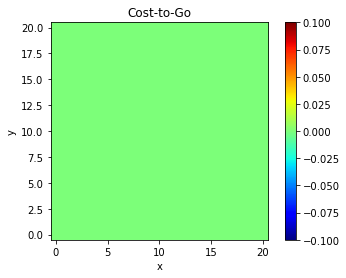

In [6]:
(fig, ax) = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Cost-to-Go")
k = ax.imshow(J_value, cmap=cm.jet)
ax.invert_yaxis()
plt.colorbar(k)
plt.show()

## Autograding
You can check your work by running the following cell:

In [7]:
from underactuated.exercises.dp.lp_dp.test_lp_dp import Testlpdp
from underactuated.exercises.grader import Grader
Grader.grade_output([Testlpdp], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 0/8.

Score for Test optimal cost-to-go from Linear Program is 0/8.
- Test Failed: False is not true : |J - J*| > 1e-6

